In [ ]:
#!apt-get -y install openjdk-8-jre-headless
#!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxtst6
Suggested packages:
  libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic fonts-ipafont-mincho
  fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 28 not upgraded.
Need to get 28.3 MB of archives.
After this operation, 104 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libxtst6 amd64 2:1.2.3-1 [12.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 openjdk-8-jre-headless amd64 8u372-ga~us1-0ubuntu1~20.04 [28.3 MB]
Fetched 28.3 MB in 1s (55.0 MB/s)
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 122532 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1_amd64.deb ...
Un

## 建立Spark物件

In [2]:
#from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, rand, split, create_map
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator 
from itertools import chain
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
#drive.mount('/content/gdrive')

In [3]:
spark = SparkSession.builder.appName("final").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/25 22:19:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/25 22:19:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/25 22:19:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## 讀檔與合併檔案
新增 holiday欄位 0表示該日要上班,2表示該日放假

In [7]:
traffic_data = spark.read.parquet("data_parquet/*/*",header = True)

calendar = spark.read.csv("108-111calendars", header=True, encoding='utf8')

calendar = calendar.drop(calendar.columns[1],calendar.columns[3]) \
              .withColumnRenamed(calendar.columns[0],"Date") \
              .withColumnRenamed(calendar.columns[2],"holiday")

data = traffic_data.join(calendar, traffic_data.發生日期 ==  calendar.Date, "inner") \
      .drop(calendar.Date)
data.printSchema()

root
 |-- 發生日期: string (nullable = true)
 |-- 發生時間: string (nullable = true)
 |-- 事故類別名稱: string (nullable = true)
 |-- 處理單位名稱警局層: string (nullable = true)
 |-- 發生地點: string (nullable = true)
 |-- 天候名稱: string (nullable = true)
 |-- 光線名稱: string (nullable = true)
 |-- 道路類別-第1當事者-名稱: string (nullable = true)
 |-- 速限-第1當事者: string (nullable = true)
 |-- 道路型態大類別名稱: string (nullable = true)
 |-- 道路型態子類別名稱: string (nullable = true)
 |-- 事故位置大類別名稱: string (nullable = true)
 |-- 事故位置子類別名稱: string (nullable = true)
 |-- 路面狀況-路面鋪裝名稱: string (nullable = true)
 |-- 路面狀況-路面狀態名稱: string (nullable = true)
 |-- 路面狀況-路面缺陷名稱: string (nullable = true)
 |-- 道路障礙-障礙物名稱: string (nullable = true)
 |-- 道路障礙-視距品質名稱: string (nullable = true)
 |-- 道路障礙-視距名稱: string (nullable = true)
 |-- 號誌-號誌種類名稱: string (nullable = true)
 |-- 號誌-號誌動作名稱: string (nullable = true)
 |-- 車道劃分設施-分向設施大類別名稱: string (nullable = true)
 |-- 車道劃分設施-分向設施子類別名稱: string (nullable = true)
 |-- 車道劃分設施-分道設施-快車道或一般車道間名稱: string (nullable = true)

In [9]:
data.groupBy("事故類別名稱").count().show()

+------------+-------+
|事故類別名稱|  count|
+------------+-------+
|          A2|3024862|
|          A1|  15026|
+------------+-------+



## Data prepocessing

In [8]:
data = data.drop("死亡受傷人數","死亡人數","受傷人數")

### 定義數值特徵



In [10]:
num_list = ["發生日期","發生時間","速限-第1當事者","當事者事故發生時年齡"]
# num_list = ["發生日期","發生時間","速限-第1當事者","當事者事故發生時年齡","死亡人數","受傷人數"]

In [11]:
for i in data.columns:
  if i in num_list:
    data = data.withColumn(i,col(i).cast("integer"))

In [12]:
data.printSchema()

root
 |-- 發生日期: integer (nullable = true)
 |-- 發生時間: integer (nullable = true)
 |-- 事故類別名稱: string (nullable = true)
 |-- 處理單位名稱警局層: string (nullable = true)
 |-- 發生地點: string (nullable = true)
 |-- 天候名稱: string (nullable = true)
 |-- 光線名稱: string (nullable = true)
 |-- 道路類別-第1當事者-名稱: string (nullable = true)
 |-- 速限-第1當事者: integer (nullable = true)
 |-- 道路型態大類別名稱: string (nullable = true)
 |-- 道路型態子類別名稱: string (nullable = true)
 |-- 事故位置大類別名稱: string (nullable = true)
 |-- 事故位置子類別名稱: string (nullable = true)
 |-- 路面狀況-路面鋪裝名稱: string (nullable = true)
 |-- 路面狀況-路面狀態名稱: string (nullable = true)
 |-- 路面狀況-路面缺陷名稱: string (nullable = true)
 |-- 道路障礙-障礙物名稱: string (nullable = true)
 |-- 道路障礙-視距品質名稱: string (nullable = true)
 |-- 道路障礙-視距名稱: string (nullable = true)
 |-- 號誌-號誌種類名稱: string (nullable = true)
 |-- 號誌-號誌動作名稱: string (nullable = true)
 |-- 車道劃分設施-分向設施大類別名稱: string (nullable = true)
 |-- 車道劃分設施-分向設施子類別名稱: string (nullable = true)
 |-- 車道劃分設施-分道設施-快車道或一般車道間名稱: string (nullable = tr

### 僅保留當事者順位為一的資料

In [13]:
data = data.filter(data.當事者順位 == "1")
data = data.drop("當事者順位")

In [14]:
data = data.drop("發生地點","道路型態大類別名稱","事故位置大類別名稱",
          "道路障礙-視距名稱","車道劃分設施-分向設施子類別名稱","當事者行動狀態大類別名稱",
          "車輛撞擊部位大類別名稱-其他","車輛撞擊部位子類別名稱-其他","肇因研判大類別名稱-個別",
          "肇因研判子類別名稱-個別","經度","緯度")

In [16]:
data.show(5)

+--------+--------+------------+------------------+--------+------------+-----------------------+--------------+------------------+------------------------+---------------------+---------------------+---------------------+-------------------+---------------------+------------------------------+-----------------+-------------------------------+--------------------------------------------+------------------------------------+----------------------------------+------------------------+------------------------+-----------------------+----------------------------+-------------------------------+-------------------------------+------+----+--------------------+----------------------------------+------------------------------------+------------------------+---------------------------+---------------------------+-------------------------+------------+-------+
|發生日期|發生時間|事故類別名稱|處理單位名稱警局層|天候名稱|    光線名稱|道路類別-第1當事者-名稱|速限-第1當事者|道路型態子類別名稱|      事故位置子類別名稱|路面狀況-路面鋪裝名稱|路面狀況-路面狀態名稱|路面狀況-路面缺陷名稱|道路障礙-障礙物名稱

### 將boolean轉成字串

In [17]:
data = data.withColumn("無或物",col("無或物").cast("string"))
data = data.withColumn("holiday",col("holiday").cast("string"))


### 將類別特徵轉換成index

In [18]:
cat_list = [i for i in data.columns if i not in num_list]
for i in cat_list:
  indexer = StringIndexer(inputCol=i, outputCol=f"{i}_numeric").setHandleInvalid("keep").fit(data)
  data = indexer.transform(data).drop(i)
cat_list = list(map(lambda x: x+"_numeric",cat_list))

In [19]:
data.printSchema()

root
 |-- 發生日期: integer (nullable = true)
 |-- 發生時間: integer (nullable = true)
 |-- 速限-第1當事者: integer (nullable = true)
 |-- 當事者事故發生時年齡: integer (nullable = true)
 |-- 事故類別名稱_numeric: double (nullable = false)
 |-- 處理單位名稱警局層_numeric: double (nullable = false)
 |-- 天候名稱_numeric: double (nullable = false)
 |-- 光線名稱_numeric: double (nullable = false)
 |-- 道路類別-第1當事者-名稱_numeric: double (nullable = false)
 |-- 道路型態子類別名稱_numeric: double (nullable = false)
 |-- 事故位置子類別名稱_numeric: double (nullable = false)
 |-- 路面狀況-路面鋪裝名稱_numeric: double (nullable = false)
 |-- 路面狀況-路面狀態名稱_numeric: double (nullable = false)
 |-- 路面狀況-路面缺陷名稱_numeric: double (nullable = false)
 |-- 道路障礙-障礙物名稱_numeric: double (nullable = false)
 |-- 道路障礙-視距品質名稱_numeric: double (nullable = false)
 |-- 號誌-號誌種類名稱_numeric: double (nullable = false)
 |-- 號誌-號誌動作名稱_numeric: double (nullable = false)
 |-- 車道劃分設施-分向設施大類別名稱_numeric: double (nullable = false)
 |-- 車道劃分設施-分道設施-快車道或一般車道間名稱_numeric: double (nullable = false)
 |-- 車道劃分設施-分道設施

### Imputation Missing Value


In [20]:
data = data.fillna(value=0)

### 將特徵轉換成vector

In [21]:
features = [i for i in data.columns if i != "事故類別名稱_numeric"]
vector = VectorAssembler(inputCols=features, outputCol='features')
transformed_data = vector.transform(data)

In [22]:
transformed_data.printSchema()

root
 |-- 發生日期: integer (nullable = true)
 |-- 發生時間: integer (nullable = true)
 |-- 速限-第1當事者: integer (nullable = true)
 |-- 當事者事故發生時年齡: integer (nullable = true)
 |-- 事故類別名稱_numeric: double (nullable = false)
 |-- 處理單位名稱警局層_numeric: double (nullable = false)
 |-- 天候名稱_numeric: double (nullable = false)
 |-- 光線名稱_numeric: double (nullable = false)
 |-- 道路類別-第1當事者-名稱_numeric: double (nullable = false)
 |-- 道路型態子類別名稱_numeric: double (nullable = false)
 |-- 事故位置子類別名稱_numeric: double (nullable = false)
 |-- 路面狀況-路面鋪裝名稱_numeric: double (nullable = false)
 |-- 路面狀況-路面狀態名稱_numeric: double (nullable = false)
 |-- 路面狀況-路面缺陷名稱_numeric: double (nullable = false)
 |-- 道路障礙-障礙物名稱_numeric: double (nullable = false)
 |-- 道路障礙-視距品質名稱_numeric: double (nullable = false)
 |-- 號誌-號誌種類名稱_numeric: double (nullable = false)
 |-- 號誌-號誌動作名稱_numeric: double (nullable = false)
 |-- 車道劃分設施-分向設施大類別名稱_numeric: double (nullable = false)
 |-- 車道劃分設施-分道設施-快車道或一般車道間名稱_numeric: double (nullable = false)
 |-- 車道劃分設施-分道設施

In [23]:
transformed_data.groupBy("事故類別名稱_numeric").count().show()

+--------------------+-------+
|事故類別名稱_numeric|  count|
+--------------------+-------+
|                 0.0|1415429|
|                 1.0|   6991|
+--------------------+-------+



### 切分訓練集以及測試集

In [24]:
train,test = transformed_data.randomSplit([0.7, 0.3], 24)

### 計算訓練集分類權重

In [26]:
import numpy as np
y_collect = train.select("事故類別名稱_numeric").groupBy("事故類別名稱_numeric").count().collect()
unique_y = [x["事故類別名稱_numeric"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark)


23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/05/25 22:54:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


{0.0: 0.5024682249470879, 1.0: 101.78736454712738}


In [27]:
mapping_expr = create_map([lit(x) for x in chain(*class_weights_spark.items())])
train = train.withColumn("weight", mapping_expr.getItem(col("事故類別名稱_numeric")))

/Users/shishihh/anaconda3/lib/python3.10/site-packages/pyspark/sql/column.py:322: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [28]:
train.show(10)

+--------+--------+--------------+--------------------+--------------------+--------------------------+----------------+----------------+-------------------------------+--------------------------+--------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------------+-----------------------------+-------------------------+-------------------------+---------------------------------------+----------------------------------------------------+--------------------------------------------+------------------------------------------+--------------------------------+--------------------------------+-------------------------------+-------------------------------+---------------------------------------+---------------------------------------+--------------+------------+--------------------+--------------------------------------------+--------------------------------+-----------------------------------+-----------------------

## Model training

### 自定義cross validation 模型

In [31]:
class CrossValidatorVerbose(CrossValidator):
    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        eva = self.getOrDefault(self.evaluator)
        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        f1_val = []
        f1_train = []

        for i in range(nFolds):
            foldNum = i + 1
            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)
            model = est.fit(train)
            prediction_val = model.transform(validation)
            prediction_train = model.transform(train)
            metric_val = (eva[0].evaluate(prediction_val)+eva[1].evaluate(prediction_val))*0.5
            f1_val.append(metric_val)
            metric_train = (eva[0].evaluate(prediction_train)+eva[1].evaluate(prediction_train))*0.5
            f1_train.append(metric_train)
            print(f"Fold {foldNum}  | F1-score | Validation: {metric_val} | Train: {metric_train}")
        
        Allmodel = est.fit(dataset)        
        avgMetrics = sum(f1_val)/len(f1_val)
        print(f"Average | F1-score | Validation: {avgMetrics} | Train: {sum(f1_train)/len(f1_train)}")

        return self._copyValues(CrossValidatorModel(Allmodel, avgMetrics))
# Reference: https://stackoverflow.com/questions/53600615/cross-validation-metrics-with-pyspark

In [32]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = '事故類別名稱_numeric',
                subsamplingRate = 0.8, featureSubsetStrategy = "sqrt", numTrees = 5, weightCol="weight")
grid = ParamGridBuilder().build()
evaluator_0 = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', metricLabel = 0.0, beta=1.0, labelCol = '事故類別名稱_numeric')
evaluator_1 = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', metricLabel = 1.0, beta=1.0, labelCol = '事故類別名稱_numeric')

In [ ]:
# random forest model
# model = rf.fit(train)
# prediction_train = model.transform(train)
# prediction_test = model.transform(test)
# metric_train = (evaluator_0.evaluate(prediction_train) + evaluator_1.evaluate(prediction_train))*0.5
# metric_test = (evaluator_0.evaluate(prediction_test) + evaluator_1.evaluate(prediction_test))*0.5
# print(f"F1-score | Train: {metric_train} | Test: {metric_test}")

In [33]:
cv = CrossValidatorVerbose(estimator=rf, estimatorParamMaps=grid, evaluator=[evaluator_0,evaluator_1], seed = 20230515, numFolds=3)

In [34]:
cvModel = cv.fit(train)

Fold 1  | F1-score | Validation: 0.47422805778245 | Train: 0.47368331209434184


Fold 2  | F1-score | Validation: 0.47002401825732393 | Train: 0.470778302289111


Fold 3  | F1-score | Validation: 0.47034371738756486 | Train: 0.47082450064819864


Average | F1-score | Validation: 0.47153193114244624 | Train: 0.4717620383438838


### 儲存模型

In [35]:
model_path = "cv_model_train_weight"
cvModel.bestModel.save(model_path)

## Evaluate

### load model

In [36]:
model = RandomForestClassificationModel.load(model_path)

### Prediction

In [37]:
prediction_test = model.transform(test)
auroc_evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC',labelCol = '事故類別名稱_numeric')
test_auroc = auroc_evaluator.evaluate(prediction_test)
metric_test = (evaluator_0.evaluate(prediction_test) + evaluator_1.evaluate(prediction_test))*0.5

In [38]:
print(f"F1-Score | Test: {metric_test}")
print(f"AUROC    | Test: {test_auroc}")

F1-Score | Test: 0.47188054696501186
AUROC    | Test: 0.7954882983251985


In [39]:
y_true = prediction_test.select(['事故類別名稱_numeric']).collect()
y_pred = prediction_test.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91    424636
         1.0       0.02      0.59      0.03      2100

    accuracy                           0.83    426736
   macro avg       0.51      0.71      0.47    426736
weighted avg       0.99      0.83      0.91    426736



### Confusion matrix

Text(0.5, 1.0, 'Testing set')

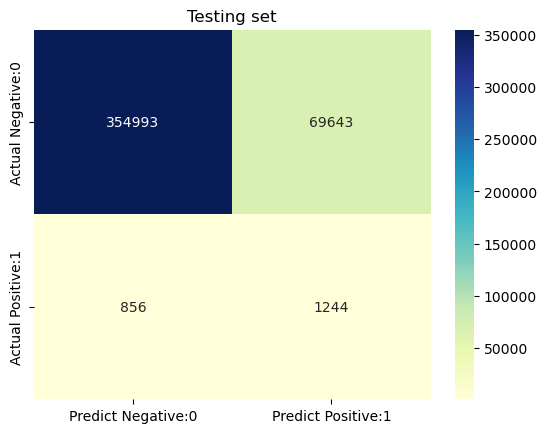

In [40]:
cm = confusion_matrix(y_true,y_pred)
cm_matrix_1 = pd.DataFrame(data=cm, index=['Actual Negative:0', 'Actual Positive:1'], columns=['Predict Negative:0','Predict Positive:1'])
ax = sns.heatmap(cm_matrix_1, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title("Testing set")

### Feature importance

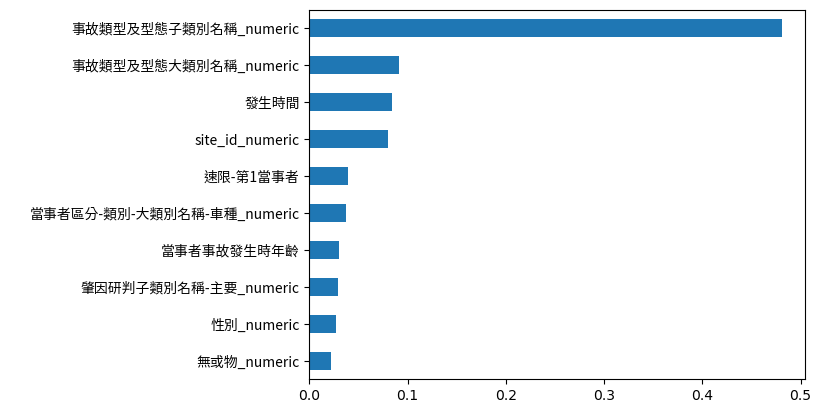

In [46]:
from matplotlib.font_manager import FontProperties as font
import matplotlib.pyplot as plt
font1 = font(fname="Noto_Sans_TC/NotoSansTC-Regular.otf")
featureImportances = model.featureImportances.toArray()
f = {"index":features, "FI" : featureImportances}
FI = pd.DataFrame(f)
FI = FI.set_index('index')
FI_10 = FI.nlargest(10,'FI').iloc[::-1]
axes = FI_10.plot(kind='barh',legend=None)
plt.ylabel(' ',fontproperties=font1)
for label in axes.get_yticklabels():
    label.set_fontproperties(font1)

In [ ]:
spark.stop()

In [ ]:
# https://towardsdatascience.com/machine-learning-on-a-large-scale-2eef3bb749ee